In [ ]:
#@title Installation of necessary liberies and solver
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!pip install -q pyomo


%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

# Optimization of an Fixed Bed Ammonia Reactor

In this notebook, the optimization design problem of a fixed bed reactor is solved using Pyomo. Originally in optimization of chemical process book the problem is solved using nonlinear optimization solver (GRG) coupled with an integrator solver. Here Using features of Pyomo, the model is discritized first and then is solved using IPOPT optimziation solver. The main goal of the problem is to find the reactor length to maximize the profit.

$ N2+3H_2 ⇌NH_3 \ \ \  ΔH_r=−26000 \ kcal/kgmol N_2 $


<a href="https://ibb.co/V3L8p1x"><img src="https://i.ibb.co/vDc8vFh/reactor-graph.jpg" alt="reactor-graph" border="0" width="400" height="300"></a>

## Reactor model
The model of reactor is defined here. To provide the optimization algorithm with good initial guess for variables like temperture of streams along the reactor, an integrator solver with a guess for the reactor length is utilized. Our guess for reactor length is 10 m for now.
In order to use the reactor length in our optimization problem later, we use an axiliary variable X which is the reactor length. Using this and making the odes of the system dimentionless, we can use X in the objective function.


In [ ]:
Cpf = 0.707 # Heat capacity of the feed gas  kcaV(kg)(K)
Cpg  = 0.719 # Heat capacity of reacting gas kcal/(kg)(K)
f  = 1.0 # Catalyst activity
dH = -26000 # Heat of reaction kcaVkg mol N2
#N # Mass flow of component designed by subscript through catalyst zone, kg mol/(m2)(h)
N1 = 8330  # Hours of operation per year
# P # Partial pressure of component designated by subscript, psi; reactor pressure is 286 psia
R = 1.987 # Ideal gas constant,  kcal/(kg mol)(K)
S1 = 10 # Surface area of catalyst tubes per unit length of reactor m
S2 = 0.78 # Cross-sectional area of catalyst zone  m2
To = 694 # Reference temperature (694 K)
U = 500 # Overall heat transfer coefficient  kcaV(h)(m2)(K)
W = 26400 # Total mass transfer flow rate  kgh
N_N2_0 = 701.2

m = ConcreteModel(name = 'Fixed Bed Reactor')

m.x = ContinuousSet(bounds=(0,1))

m.X = Var(domain=NonNegativeReals, initialize=10) # This variable is defined as reactor length

# m.X = 10
m.Tf = Var(m.x, domain=NonNegativeReals)
m.Tg = Var(m.x, domain=NonNegativeReals)
m.N_N2 = Var(m.x, domain=NonNegativeReals)
m.dTf = DerivativeVar(m.Tf, wrt=m.x)
m.dTg = DerivativeVar(m.Tg, wrt=m.x)
m.dN_N2 = DerivativeVar(m.N_N2, wrt=m.x)


K1 = lambda m,x: 1.78945e4*exp(-20800/(R*m.Tg[x]))
K2 = lambda m,x: 2.5714e16*exp(-47400/(R*m.Tg[x]))

P_N2 = lambda m,x: 286*m.N_N2[x]/(2.598*N_N2_0 + 2*m.N_N2[x])
P_H2 = lambda m,x: P_N2(m,x)*3
P_NH3 = lambda m,x:  286*(2.23*N_N2_0-2*m.N_N2[x])/(2.598*N_N2_0 + 2*m.N_N2[x])

rx = lambda m,x: ( K1(m,x)*P_N2(m,x)*(P_H2(m,x)**1.5)/P_NH3(m,x) - K2(m,x)*P_NH3(m,x)/(P_H2(m,x)**1.5) )

m.ode1 = Constraint(m.x, rule = lambda m, x: m.dTf[x] == m.X*(-U*S1/(W*Cpf)*(m.Tg[x] - m.Tf[x])) )
m.ode2 = Constraint(m.x, rule = lambda m, x: m.dTg[x] == m.X*(-U*S1/(W*Cpg)*(m.Tg[x] - m.Tf[x]) + (-dH)*S2/(W*Cpg)*f*rx(m,x)) )
m.ode3 = Constraint(m.x, rule = lambda m, x:  m.dN_N2[x] == m.X*(-f*rx(m,x)) )

# intial condition for ode eqs

m.Tf[0].fix(694)
m.Tg[0].fix(694)
m.N_N2[0].fix(701.2)


In [ ]:
sim = Simulator(m, package='scipy')
xsim, profiles = sim.simulate(numpoints=100, integrator='lsoda')

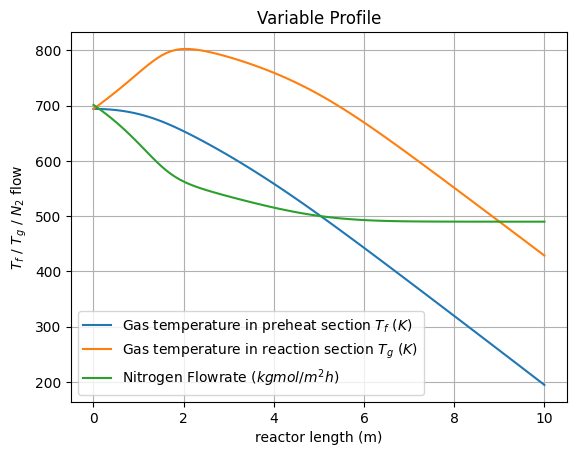

In [ ]:
lines = plt.plot(xsim*10,profiles);

plt.xlabel('reactor length (m)')
plt.ylabel('$T_f$ / $T_g$ / $N_2$ flow')
plt.legend(lines,['Gas temperature in preheat section $T_f \ (K)$',\
                  'Gas temperature in reaction section $T_g \ (K)$',\
                  'Nitrogen Flowrate $(kgmol/m^2h)$']);
plt.grid()

## Optimization
In this section, the variables along the ractor length discritized using collocation method. Therefore, the whole ode problem tranformed to just a set of nonlinear equation which can be solved using any nonlinear solver. However we not only want to solve these nonlinear equations for model definition we also want to maximize the economic return. Additionally, as it is shown in the above figure the temperature of feed gas is about 200 K which is infeasible. Therefore, a constraint for the minimum amount of feed temperature is added to the model.

In [ ]:
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=15)
sim.initialize_model()

In [ ]:
# additional condition
m.eq4 = Constraint(expr= m.Tf[1] >= 400 )

# objective function
f = 1.33563e07 - 1.70843e04*m.N_N2[1] + 704.09*(m.Tg[1]-To) - \
    699.27*(m.Tf[1]-To) - sqrt(3.45663e07 + 1.98365e09*m.X) # Objective function, $/year
m.obj = Objective(expr=f/1e6, sense=maximize)

# Solver selection and solving the optimization model
SolverFactory('ipopt').solve(m,tee=True)

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1256
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      271

Total number of variables............................:      274
                     variables with only lower bounds:      136
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 274, 'Number of variables': 274, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.13\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.07045388221740723}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Results

 Reactor length = 6.695 m
 Economic Return = 5.0154 milion$/year



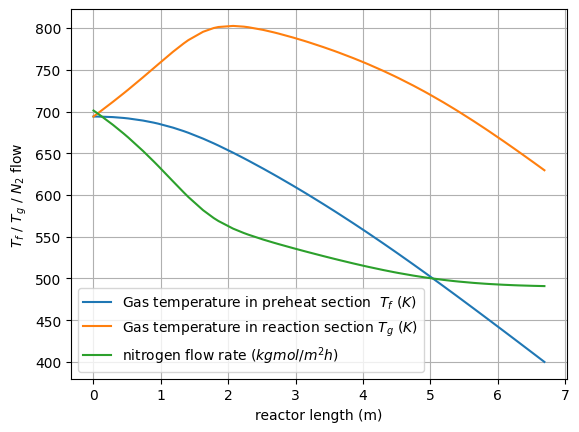

In [ ]:
xi = [value(i)*value(m.X) for i in m.x]
Tfi = [value(m.Tf[i]) for i in m.x]
Tgi = [value(m.Tg[i]) for i in m.x]
N_N2i = [value(m.N_N2[i]) for i in m.x]
print(f' Reactor length = {value(m.X):.3f} m')
print(f' Economic Return = {value(m.obj):.4f} milion$/year')
print('')
plt.xlabel('reactor length (m)')
plt.ylabel('$T_f$ / $T_g$ / $N_2$ flow')
plt.plot(xi,Tfi, label='Gas temperature in preheat section  $T_f \ (K)$')
plt.plot(xi,Tgi, label='Gas temperature in reaction section $T_g \ (K)$')
plt.plot(xi,N_N2i, label='nitrogen flow rate $(kgmol/m^2h)$')
plt.legend()
plt.grid();



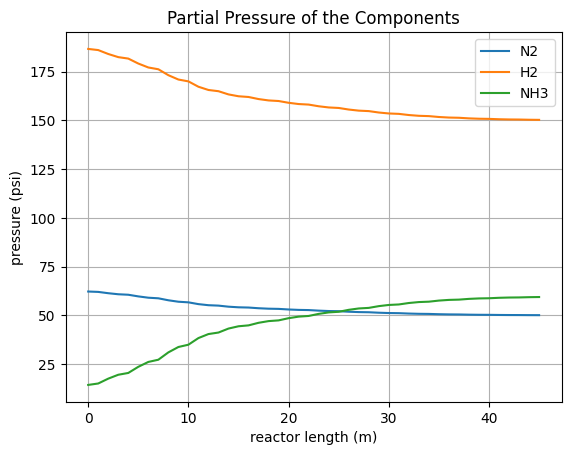

In [ ]:
P_N2_i = [value(P_N2(m,i)) for i in xi]
P_H2_i = [value(P_H2(m,i)) for i in xi]
P_NH3_i = [value(P_NH3(m,i)) for i in xi]
plt.plot(P_N2_i, label='N2')
plt.plot(P_H2_i, label='H2')
plt.plot(P_NH3_i, label='NH3')
plt.title('Partial Pressure of the Components')
plt.xlabel('reactor length (m)')
plt.ylabel('pressure (psi)')
plt.grid()
plt.legend();